# Cultural project

This project is dedicated to the application of machine learning algorithms and tools to analysis of anthropological and sociological datasets. We would experiment with both supervised and unsupervised learning algorithms, such as clustering, decision trees, association rules, and artificial neural networks and many others. The goal is to extract meaningful patterns from such datasets as World Value Survey.

Before we apply any algorithms to the WVS data, we need to make sure that the data has high quality. We need to detect and correct corrupt, invalid, or inaccurate records from the data set and changing the range of data value for easiler processing later.

## Required Files

data_0.csv: data with headers(the title of questions)  
data_1.csv: data with several most representative country in each cluster, and missing values removed/imputed & columns combined  
data_2.csv: data with religion code transformed and ready to use

----------------------------------------------------
data_3.csv: normalized data & convert categorical into numeric for clustering  
data_4.csv: data with labels from clustering

## 2. Clustering & evaluation

After cleaning up data and normilizing data, we can begin to use kmeans model implemented in sklearn to cluster data.  
We compute SSE for each cluster size, plot it on the graph and try to find an elbow point that indicated the best k value.  

### 2.1 Find the best k for kmeans clustering

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("../data_set/cultural_data/clean_data/data_3.csv")

3
4
5
6
7
8
9
10
11


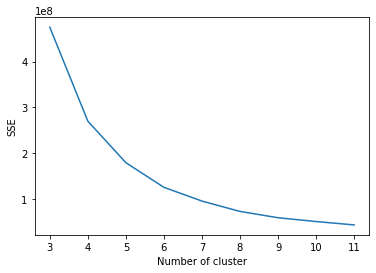

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

sse = {}
for i in range(3,12):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    sse[i] = kmeans.inertia_ 
    print(i)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


We choose k = 7 to perform kmeans clustering and output cluster result for each country to result.csv

In [3]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(data)
labels = kmeans.labels_

data["label"] = labels
result = data.groupby(["label","V2"]).agg({'V4': ["count"]}).reset_index()
result.rename(columns={"label": "cluster", "V2": "country_label","V4":"number_of_respondents"}, inplace=True)

data.to_csv("../data_set/cultural_data/clean_data/data_4.csv", index = False)
result.to_csv("../data_set/cultural_data/clean_data/result.csv", index = False)


### 2.2 Visualize cluster result

We first clean clustering result and output clusters for each country to country_result.csv. We can then use this result to visualize the culture cluter on the google map in 01.html

In [5]:
country = pd.read_csv("../data_set/cultural_data/clean_data/country.csv")

data["label"] = labels
result = data.groupby(["label","V2"]).agg({'V4': ["count"]}).reset_index()
result.rename(columns={"label": "cluster", "V2": "country_label","V4":"number_of_respondents"}, inplace=True)

country_result = pd.concat([data["V2"],data["label"]], axis=1, keys=['country', 'cluster'])
country_result = country_result.groupby(["country","cluster"]).agg({'country': ["count"]}).reset_index()

country_result.to_csv("../data_set/cultural_data/clean_data/country_result.csv", index = False)
country_result = pd.read_csv("../data_set/cultural_data/clean_data/country_result.csv", skiprows=[1])
country_result = country_result.drop(columns=["country.1"])

country_result["country"] = [country[country['index'] == x]['name'].iloc[0] for x in country_result["country"]]
print(country_result.values.tolist())

result.to_csv("../data_set/cultural_data/clean_data/result.csv", index = False)
country_result.to_csv("../data_set/cultural_data/clean_data/country_result.csv", index = False)


[['Algeria', 2], ['Argentina', 2], ['Australia', 2], ['Brazil', 2], ['Chile', 4], ['China', 4], ['Colombia', 4], ['Ecuador', 4], ['Estonia', 4], ['Georgia', 4], ['Germany', 4], ['Hong Kong', 1], ['India', 1], ['Iraq', 1], ['Japan', 1], ['Kazakhstan', 1], ['Jordan', 1], ['South Korea', 1], ['Kyrgyzstan', 1], ['Lebanon', 1], ['Libya', 6], ['Malaysia', 6], ['Mexico', 6], ['Netherlands', 6], ['Nigeria', 3], ['Pakistan', 3], ['Peru', 3], ['Philippines', 3], ['Poland', 3], ['Romania', 3], ['Russia', 3], ['Rwanda', 3], ['Singapore', 5], ['South Africa', 5], ['Zimbabwe', 5], ['Spain', 5], ['Sweden', 5], ['Thailand', 5], ['Tunisia', 0], ['Turkey', 0], ['Ukraine', 0], ['Egypt', 0], ['United States', 0], ['Uruguay', 0], ['Yemen', 0]]


We then visualize the result with confusion matrix.

45


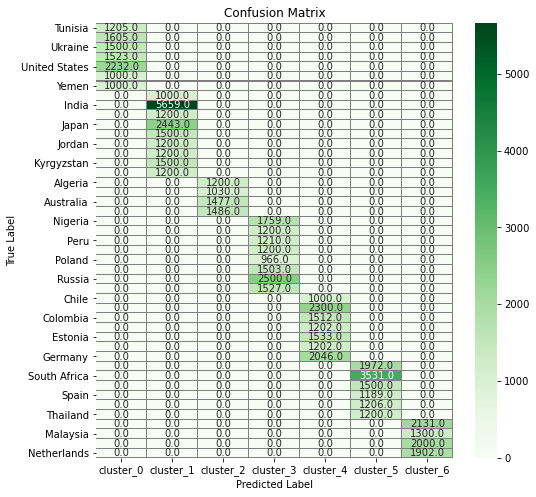

In [6]:
import seaborn as sns

conf_index = [country[country["index"] == x]["name"].iloc[0] for x in result["country_label"]]
conf_index = pd.Series(conf_index).drop_duplicates().tolist()
print(len(conf_index))
conf_mtr = pd.DataFrame(columns=["cluster_"+str(x) for x in range(7)],
                       index=conf_index)

for i in range(conf_mtr.shape[1]):
    col = conf_mtr.columns[i]
    country_label = list(result[result["cluster"]==i]["country_label"])
    country_name_label = [country[country["index"] == x]["name"].iloc[0] for x in country_label]

    respondents = list(result[result["cluster"]==i]["number_of_respondents"]["count"])

    for j in range(len(country_label)):
        conf_mtr[col].loc[country_name_label[j]] = respondents[j]

conf_mtr.fillna(0,inplace=True)
conf_mtr.to_csv("../data_set/cultural_data/clean_data/conf_mtr.csv", index = True)

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mtr, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

We can then apply PCA and visualize the data labels and cultural groups in 2d and 3d.

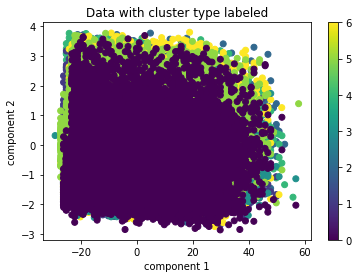

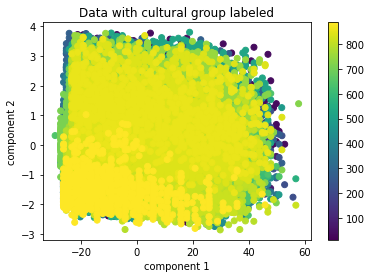

In [7]:
from sklearn.decomposition import PCA
%matplotlib inline

pca = PCA(n_components=2)
projected = pca.fit_transform(data.iloc[:,1:-2])

plt.scatter(projected[:, 0], projected[:, 1], c=data.label)
plt.title("Data with cluster type labeled")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

plt.scatter(projected[:, 0], projected[:, 1], c=data.V2)
plt.title("Data with cultural group labeled")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

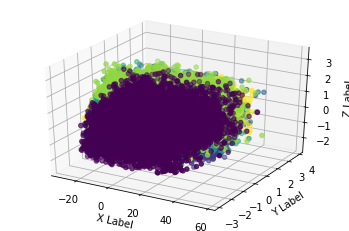

In [8]:
# 3d data visualization with cluster type labeled by color
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
projected = pca.fit_transform(data.iloc[:,1:-2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=data.label, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


### 2.3 Evalute cluster result

We first want to check if the repondents from the same country ends up in the same cluster. We set k = 45 for kmeans clustering and show result by confusion matrix.

45


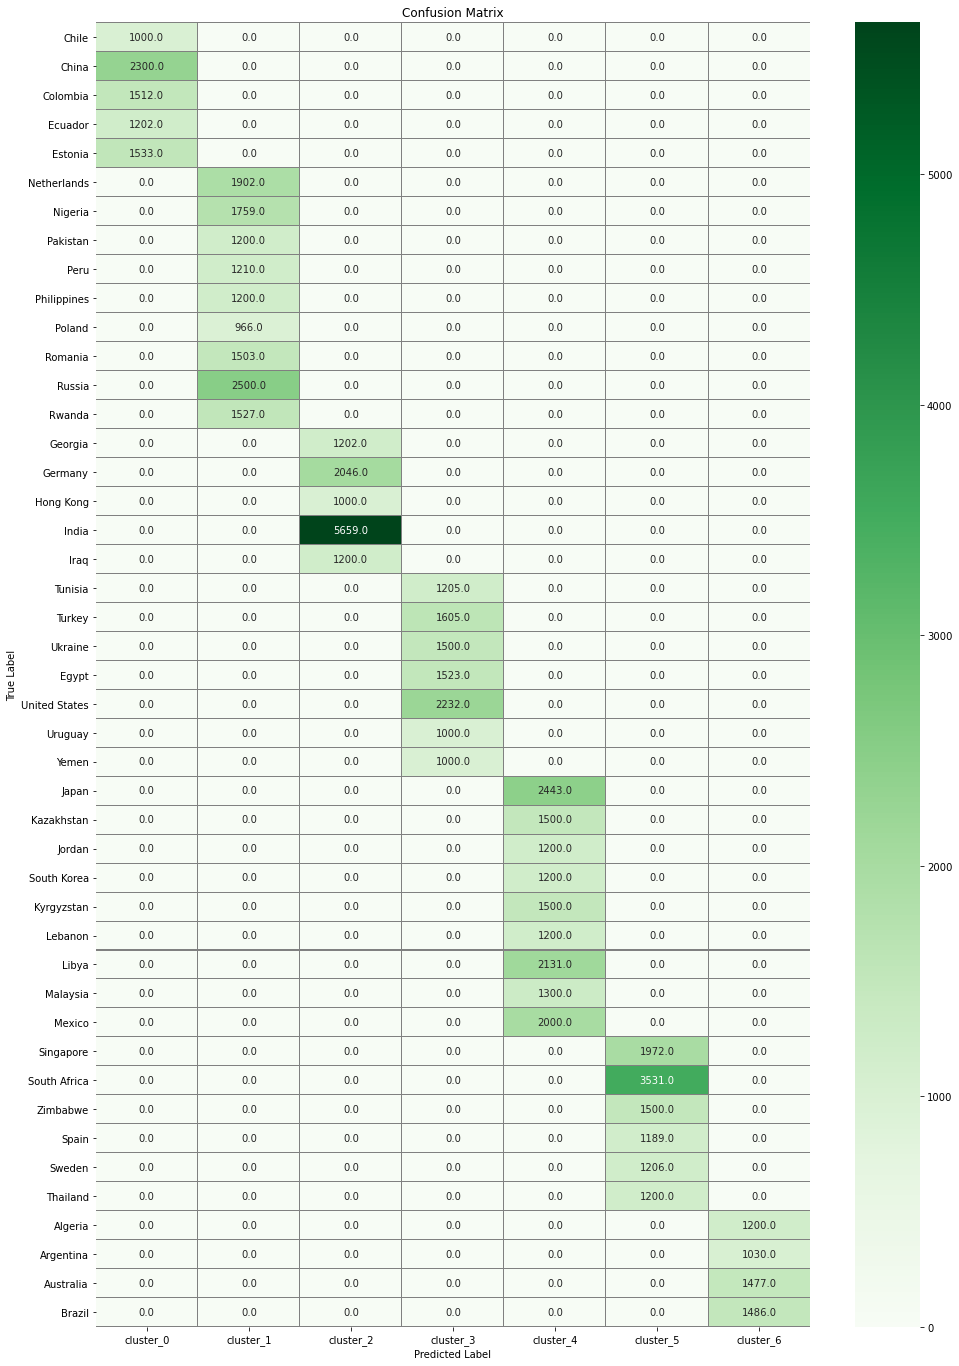

In [9]:
data = pd.read_csv("../data_set/cultural_data/clean_data/data_3.csv")

kmeans = KMeans(n_clusters=7)
kmeans.fit(data)
labels = kmeans.labels_

data["label"] = labels
result = data.groupby(["label","V2"]).agg({'V4': ["count"]}).reset_index()
result.rename(columns={"label": "cluster", "V2": "country_label","V4":"number_of_respondents"}, inplace=True)

conf_index = [country[country["index"] == x]["name"].iloc[0] for x in result["country_label"]]
conf_index = pd.Series(conf_index).drop_duplicates().tolist()
print(len(conf_index))
conf_mtr = pd.DataFrame(columns=["cluster_"+str(x) for x in range(7)],
                       index=conf_index)

for i in range(conf_mtr.shape[1]):
    col = conf_mtr.columns[i]
    country_label = list(result[result["cluster"]==i]["country_label"])
    country_name_label = [country[country["index"] == x]["name"].iloc[0] for x in country_label]

    respondents = list(result[result["cluster"]==i]["number_of_respondents"]["count"])

    for j in range(len(country_label)):
        conf_mtr[col].loc[country_name_label[j]] = respondents[j]

conf_mtr.fillna(0,inplace=True)
conf_mtr.to_csv("../data_set/cultural_data/clean_data/conf_mtr_full.csv", index = True)

f,ax = plt.subplots(figsize=(16, 24))
sns.heatmap(conf_mtr, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()